### Daily R value derived from number of cases reported in LA county
Mehrdad Kiamari, Bhaskar Krishnamachari - June 2020

To monitor the severity of any epidemic, it is crucial to look at $R_t$ which is a value representing the effective reproduction number (the number of individuals who are infected per infectious individual at time $t$) of the disease. 

Regarding $R_t$, the epidemic will exponentially grow among the population when $R_t >> 1$. However, the epidemic sloowly disappear as $R_t<1$. Since restirctions would eventually impactts $R_t$, this measure can guide authorities to take appropriate actions regarding tightening or loosing restrictions for the sake of having economic prosperity and human safety.   

In this code, we aim at estimating daily R value of COVID-19 in LA county. Our approach is universal and can be utilized for any area. We use SIR model, i.e.

$$
\begin{align}
\frac{dS}{dt} &= -\beta \frac{SI}{N}\\
\frac{dI}{dt} &= +\beta \frac{SI}{N} - \sigma I\\
\frac{dR}{dt} &= \sigma I
\end{align}
$$

where $S$, $I$, and $R$ represent the number of Susceptible, Infected, and Recovered people in a population size of $N$. Regarding the parameter $\sigma = \frac{1}{D_i}$, $D_i$ represents the average infectious days.

As far as $R$ is concerned, it is equal to $\frac{\beta}{\sigma}$. Our idea is to estimate $\beta$ at each time from the above differential equation which involves $\frac{dI}{dt}$, then calculate the corresponding $R$.

In [1]:
import json
import re
import matplotlib.pyplot as plt
from matplotlib.pyplot import subplots
import numpy as np
from matplotlib.colors import hsv_to_rgb
from itertools import combinations
import pandas as pd
from scipy.optimize import fsolve

from gekko import GEKKO
from matplotlib.dates import date2num, num2date
from matplotlib import dates as mdates
from matplotlib import ticker
from matplotlib.colors import ListedColormap
from matplotlib.patches import Patch
from scipy.interpolate import interp1d

from IPython.display import clear_output
%config InlineBackend.figure_format = 'retina'

Create a dictionary consisting of communities and their population as keys and values, respectively. 

In [2]:
with open('population.json') as json_file_pop:
	data_population = json.load(json_file_pop)

Function to check if the communitiy exists in the dictionary for population

In [3]:
def check_if_community_is_in_dic_pop(community_name):
	with open('population.json') as json_file_pop:
		data_population = json.load(json_file_pop)
		temp = [val for key,val in data_population.items() if community_name == key.strip().split('--')[0]]
		if len(temp)==1:
			#print(community_name,"found")
			return True
		#print(community_name,"NOT found")    
		return False

### Side Class and Functions

Each community is an object with few attributes such as name, number of daily or cumulative cases, etc.


In [4]:
class community:
	def __init__(self,name,actual_name,Today_date):
		self.name = name
		self.Today_date = Today_date
		self.actual_name = actual_name # for displaying part of figures
		# cumulative total
		self.confirmed = np.zeros(len(range(16,self.Today_date)),dtype=int)
		self.confirmed_daily = np.zeros(len(range(16,self.Today_date)),dtype=int)
	# for adding new entry for each community on every day 	
	def check_validity_new_entry(self,day):
		index = day - 16
		if index == 0:
			return True
		else:
			if self.confirmed[index] >= self.confirmed[index-1]:
				return True
			return False		
	def update_confirmed_cases(self,day):
		#print("before")
		#print(self.confirmed)
		index = day - 16
		while index != 0:
			if self.confirmed[index] < self.confirmed[index-1]:
				self.confirmed[index-1] = self.confirmed[index]
			index -= 1
		#print("after")
		#print(self.confirmed)
	def addnumber(self,day, number):
		index = day - 16
		self.confirmed[index] = number
		status_validity_of_entry = self.check_validity_new_entry(day)
		if not status_validity_of_entry:
			self.update_confirmed_cases(day)

	# return the confirmed cases (either daily or cumulative) for each community		
	def plot_info(self,type_plot):
		output = np.zeros(len(range(16,self.Today_date)),dtype=int)
		for index,i in enumerate(list(range(16,self.Today_date))):
			# for daily
			if type_plot == 'daily':
				# if i in self.dic_confirmed.keys():
				# 	output[index] =  self.dic_confirmed[i]
				# else:
				# 	output[index] = 0
				output = self.confirmed_daily
			# for cumulative
			else:
				output = self.confirmed
		return output	

# get population for top selected communities    
def get_population_vec(list_communities):
	with open('population.json') as json_file_pop:
		data = json.load(json_file_pop)
		
		output_list = []
		for communiuty_obj in list_communities:
			temp = [val for key,val in data.items() if communiuty_obj.actual_name == key.strip().split('--')[0]]
			if temp :
		 		output_list.append(int(temp.pop().strip()))
		if len(output_list) == len(list_communities):
			output = np.asarray(output_list)
		else:
			raise NameError('The name of one of communities has NOT been found!')	

		return output

# create matrix for number of infections for top selected communities    
def create_matrix(list_selected_communities,type_plot,til_date):
	# matrix_I  has c rows (communities) and T columns (days) 
	#matrix_I =  np.zeros((len(list_selected_communities),len(range(16,list_selected_communities[0].Today_date)) ))
	matrix_I =  np.zeros((len(list_selected_communities),til_date ))
	for i,communiuty_obj in  enumerate(list_selected_communities):
		I_s_this_community_obj = communiuty_obj.plot_info(type_plot)[:til_date]
		#print("row", i, communiuty_obj.name)
		for j,infected_at_this_day in enumerate(I_s_this_community_obj):
			 matrix_I[i,j] = infected_at_this_day
	return matrix_I	 

# matrix I is supposed to be increasing for each community, so we fix any drop by this function
def fix_matrix_I(matrix_I):
    output = np.zeros_like(matrix_I)
    output[:,0] = matrix_I[:,0]
    r,c = matrix_I.shape[0], matrix_I.shape[1]
    for ind_r in range(r):
        for ind_c in range(1,c):
            if matrix_I[ind_r,ind_c] < matrix_I[ind_r,ind_c-1]:
                output[ind_r,ind_c] = matrix_I[ind_r,ind_c-1]
            else:
                output[ind_r,ind_c] = matrix_I[ind_r,ind_c]
    return output            

In [5]:
def find_intial_non_zero_val_Infection(ref_matrix_I):
# output : non-zero values for each city    
	vec = np.zeros((ref_matrix_I.shape[0],))
	for city in range(ref_matrix_I.shape[0]):
		for time in range(ref_matrix_I.shape[1]):
			if ref_matrix_I[city,time] != 0:
				vec[city] = ref_matrix_I[city,time]
				break
	return vec			

def function_for_solver(z,*data):
    next_I,curr_I,sigma,N = data
    beta = z
    
    F = 0
    F = ((1/(beta-sigma))*np.log(next_I/((beta-sigma)-beta*next_I/N))) -  ((1/(beta-sigma))*np.log(curr_I/((beta-sigma)-beta*curr_I/N))) - 1.0 # equations

    return F   
def solve_beta_for_single_time_polynomial(next_I,curr_I,sigma,N,prev_beta):
#      
	if curr_I != 0:
# 		m = GEKKO()             # create GEKKO model
# 		beta = m.Var(value=1.0)      # define new variable, initial value=0
# 		m.Equations([(beta-sigma)*curr_I -  (beta/N)*(curr_I**2) == next_I - curr_I ]) # equations
# 		m.solve(disp=False)     # solve
# 		# not being negative
# 		output = max(beta.value[0],0)
		output = (next_I - curr_I+sigma*curr_I)/(curr_I-(1/N)*curr_I**2)
	else:
		output = prev_beta

	#print(beta.value[0])
	return output 	
def solve_beta_for_single_time_exponential(next_I,curr_I,sigma,N,prev_beta):

	#clear_output(wait=True)    
	#print("curr", curr_I, "next", next_I)
# 	if next_I != 0 and curr_I != 0 and next_I != curr_I:
# 		m = GEKKO()             # create GEKKO model
# 		beta = m.Var(value=1.0)      # define new variable, initial value=0
# 		m.Equations([((1/(beta-sigma))*m.log(next_I/((beta-sigma)-beta*next_I/N))) -  ((1/(beta-sigma))*m.log(curr_I/((beta-sigma)-beta*curr_I/N))) == 1.0]) # equations
# 		m.solve(disp=False)     # solve
# 		output = beta.value[0]
# 	else:
# 		output = solve_beta_for_single_time_polynomial(next_I,curr_I,sigma,N,prev_beta)
##################################
# 	data = (next_I,curr_I,sigma,N)
# 	beta_guess = .2
#	output = fsolve(function_for_solver, beta_guess, args=data)
#################################
	output = solve_beta_for_single_time_polynomial(next_I,curr_I,sigma,N,prev_beta)	
	return output 
def calculating_beta(matrix_I,vec_population,sigma,Today_date, name_top_selected_communities):
	r,c = matrix_I.shape[0] , matrix_I.shape[1]
	matrix_beta = np.zeros((r,c-1))
	R = np.zeros((r,c-1))
	for city in range(r):
		prev_beta = 0
		for time in range(c-1):
			clear_output(wait=True)  
			print("beta for city:",city)
			matrix_beta[city,time] = max(0,solve_beta_for_single_time_exponential(matrix_I[city,time+1],matrix_I[city,time],sigma,vec_population[city],prev_beta) )
			prev_beta = matrix_beta[city,time]
			R[city,time] = matrix_beta[city,time] / sigma

	clear_output(wait=True) 
# 	print("DONJE")

	return matrix_beta

def calculate_R_margin_for_single_time(next_I,curr_I,sigma,N):
    # D is ave recovery time in days
    if curr_I != 0: 
        D = 1/sigma;
        std= 4.5
        sigma = 1/(D-std) 
        down = max((next_I- curr_I)/( sigma*(curr_I- (1/N)*curr_I**2) ) + (1/(1-curr_I/N)),0)

        factor = 10
        next_I, curr_I = factor*next_I, factor*curr_I
        sigma = 1/(D+std) 
        up = max((next_I- curr_I)/( sigma*(curr_I- (1/N)*curr_I**2) ) + (1/(1-curr_I/N)),0)
    else:
        down, up = 0, 0
    return down,up

def calculating_R_marigins(matrix_I,vec_population,sigma,Today_date, name_top_selected_communities):
	r,c = matrix_I.shape[0] , matrix_I.shape[1]
#	matrix_beta = np.zeros((r,c-1))
	U = np.zeros((r,c-1))
	D = np.zeros((r,c-1))
	for city in range(r):
		for time in range(c-1):
			#clear_output(wait=True)             
			#print("Margin for city",city)
			margin = calculate_R_margin_for_single_time(matrix_I[city,time+1],matrix_I[city,time],sigma,vec_population[city]) 
			D[city,time],U[city,time] = margin[0],margin[1]


# 	clear_output(wait=True) 
# 	print("Margin len",D.shape[1],U.shape[1] )

	return D,U
    

### Load CSV File

In [6]:
states1 = pd.read_csv('Covid-19.csv', usecols=[0,1,4],
                     index_col=['Region', 'Time Stamp'],
                     parse_dates=['Time Stamp'],
                     squeeze=True).sort_index()
states = states1.groupby(['Region', 'Time Stamp']).sum()
states.head()
#print(states['Melrose']['2020-03-16'])

Region  Time Stamp
Acton   2020-03-28    0
        2020-03-29    0
        2020-03-30    0
        2020-03-31    0
        2020-04-01    0
Name: Number of cases, dtype: int64

### Create DataFrame 
Make DataFrame for R

In [7]:
def create_dataframe_for_R(ind_city,matrix_beta,sigma,U,D):  
    r,c = matrix_beta.shape[0],matrix_beta.shape[1]
    data={}
    data['R'] = matrix_beta[ind_city,:]/sigma
    data['Upper'] = U[ind_city,:]
    data['Lower'] = D[ind_city,:]
    #print(len(data['R']),len(data['Upper']),len(data['Lower']))
    data['Time Stamp'] = pd.date_range(start='2020-03-16', periods=c)    
    dataset = pd.DataFrame(data)
    dataset.set_index(['Time Stamp'], inplace=True)    
    #print(dataset)
    return dataset    

### Plot Func for R along its confidence interval

In [8]:
def plot_rt(result, ax, state_name):
    
    ax.set_title(f"{state_name}")
    
    # Colors
    ABOVE = [1,0,0]
    MIDDLE = [1,1,1]
    BELOW = [0,0,0]
    cmap = ListedColormap(np.r_[
        np.linspace(BELOW,MIDDLE,25),
        np.linspace(MIDDLE,ABOVE,25)
    ])
    color_mapped = lambda y: np.clip(y, .5, 1.5)-.5
    
    index = result['R'].index.get_level_values('Time Stamp')
    values = result['R'].values
    
    # Plot dots and line
    ax.plot(index, values, c='k', zorder=1, alpha=.25)
    ax.scatter(index,
               values,
               s=40,
               lw=.5,
               c=cmap(color_mapped(values)),
               edgecolors='k', zorder=2)
    
    # Aesthetically, extrapolate credible interval by 1 day either side
    lowfn = interp1d(date2num(index),
                     result['Lower'].values,
                     bounds_error=False,
                     fill_value='extrapolate')
    
    highfn = interp1d(date2num(index),
                      result['Upper'].values,
                      bounds_error=False,
                      fill_value='extrapolate')
    
    extended = pd.date_range(start=pd.Timestamp('2020-03-16'),
                             end=index[-1]+pd.Timedelta(days=1))
    
    ax.fill_between(extended,
                    lowfn(date2num(extended)),
                    highfn(date2num(extended)),
                    color='k',
                    alpha=.1,
                    lw=0,
                    zorder=3)

    ax.axhline(1.0, c='k', lw=1, label='$R_t=1.0$', alpha=.25);
    
    # Formatting
    ax.xaxis.set_major_locator(mdates.MonthLocator())
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%b'))
    ax.xaxis.set_minor_locator(mdates.DayLocator())
    
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_formatter(ticker.StrMethodFormatter("{x:.1f}"))
    ax.yaxis.tick_right()
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.margins(0)
    ax.grid(which='major', axis='y', c='k', alpha=.1, zorder=-2)
    ax.margins(0)
    ax.set_ylim(0.0,10.0)
    ax.set_xlim(pd.Timestamp('2020-03-16'), result.index.get_level_values('Time Stamp')[-1]+pd.Timedelta(days=1))
    #fig.set_facecolor('w')


    


### Moving Average for Smoothing

In [9]:
 def movingaverage(values, window):
    weights = np.repeat(1.0, window)/window
    sma = np.convolve(values, weights, 'valid')
    return sma

#  def movingaverage (values, window):
#     weights = np.repeat(1.0, window)/window
#     sma = np.convolve(values, weights)
#     print("l",len(sma))
#     print(len(values))
#     print(window)
#     import pdb;pdb.set_trace()
#     return sma

def moving_ave_on_matrix(matrix_I,n):
    #n=7      
    padded_I = np.zeros((matrix_I.shape[0],matrix_I.shape[1] + n-1 ))

    padded_I[:,(n-1)//2:-(n-1)//2]=matrix_I
    for city in range(matrix_I.shape[0]):
        matrix_I[city,:] = movingaverage(padded_I[city,:],n)
    return matrix_I

### Considering a Gaussian Distribution for both parameter $D_I$ (recovery time) and factor $k$ (ratio of actual confirmed cases to reported ones)
Setting the mean and var of PDFs

In [10]:
mean_D = 7.5
var_D = 4.5

min_k_value = 1.0
max_k_value = 40.0
mean_k = .5*(min_k_value+max_k_value)
var_k = ((max_k_value-min_k_value)/6)**2

### PDFs of parameters $D_I$, $k$, and infection rate $R_t$ 

In [11]:
def pdf_normal(x,mean,var):
	return (1/np.sqrt(2*np.pi*var))*np.exp(-.5*(1/var)*((x-mean)**2))

In [12]:
def pdf_k(x,min_k_value,max_k_value):
	mean = .5*(min_k_value+max_k_value)
	var = ((max_k_value-min_k_value)/6)**2
	return (1/np.sqrt(2*np.pi*var))*np.exp(-.5*(1/var)*((x-mean)**2))

def pdf_k_uniform(x,min_k_value,max_k_value):
	if min_k_value <= x and x <= max_k_value:
		return 1/(max_k_value-min_k_value)
	return 0

# def convert_into_input_argument_pdf_k(x,next_I,curr_I,N,r):
# 	return (N/curr_I)*(1-(1+((next_I-curr_I)/curr_I)/x)/r)
# def pdf_R_for_single_r(next_I,curr_I,N,r,mean_sigma,var_sigma,min_k_value,max_k_value):
# 	#range_sigma = np.arange(1/(7.5+4.5),1/(7.5-4.5),0.01)
# 	range_sigma = np.arange(-200,200,0.01)    
# 	input_argument_pdf_k = list(map(lambda x:convert_into_input_argument_pdf_k(x,next_I,curr_I,N,r),range_sigma))
# 	val_pdf_k = list(map(lambda x:pdf_k(x,min_k_value,max_k_value),input_argument_pdf_k))
# 	val_pdf_sigma = list(map(lambda x:pdf_normal(x,mean_sigma,var_sigma),range_sigma))
# 	coeff = list(map(lambda x:(N/curr_I)-convert_into_input_argument_pdf_k(x,next_I,curr_I,N,r),range_sigma))
# 	print("INPUT K",input_argument_pdf_k)
# 	#plt.plot(range(len(range_sigma)),val_pdf_sigma)
# 	#plt.plot(range(len(range_sigma)),val_pdf_k,'r')
# 	#plt.plot(range(len(range_sigma)),coeff,'g')
# 	#plt.show()
# 	#import pdb;pdb.set_trace()

def pdf_R_for_single_r(next_I,curr_I,N,r,mean_D,var_D,min_k_value,max_k_value):
	#range_sigma = np.arange(1/(7.5+4.5),1/(7.5-4.5),0.01)
	a , b = curr_I/N , (next_I-curr_I)/curr_I   
	meanD, varD = mean_D,var_D
	step_z = 0.01    
	z = np.arange(0,200,step_z)    
	input_argument_pdf_sigma = list(map(lambda x:(r*(1-x*a)-1)/b,z))
	val_pdf_k = list(map(lambda x:pdf_k(x,min_k_value,max_k_value),z))
	val_pdf_sigma = list(map(lambda x:pdf_normal(x,meanD,varD),input_argument_pdf_sigma))
	#coeff = list(map(lambda x:np.absolute((b*(1-x*a))/((1-r*(1-x*a))**2)),z))
	coeff = list(map(lambda x:np.absolute((1-x*a)/b),z))
	#print("INPUT K",input_argument_pdf_k)
	#plt.plot(range(len(range_sigma)),val_pdf_sigma)
	#plt.plot(range(len(range_sigma)),val_pdf_k,'r')
	#plt.plot(range(len(range_sigma)),coeff,'g')
	#plt.show()
	#import pdb;pdb.set_trace()
    
    
	#print("f_R(r)",r,sum(np.multiply(np.multiply(coeff,val_pdf_sigma),val_pdf_k))*step_z) 
	#print("f_R(r)")    
	return sum(np.multiply(np.multiply(coeff,val_pdf_sigma),val_pdf_k)*step_z)

In [13]:
def cal_delta(next_I,curr_I,N,ave_r,desired_prob,mean_sigma,var_sigma,min_k_value,max_k_value):
    prob, index, dr = 0,0,0.01
#     #print("--",MIN_R_range,Max_R_range)
#     range_r = np.arange(0,10,.1)

#     y = list(map(lambda x:pdf_R_for_single_r(next_I,curr_I,N,x,mean_D,var_D,min_k_value,max_k_value),range_r))
#     plt.plot(range_r,y)
#     print("sum pdf",sum(y))
#     plt.show()
#     return 0
    r = ave_r
    prob = pdf_R_for_single_r(next_I,curr_I,N,r,mean_D,var_D,min_k_value,max_k_value)*dr
    
    ind_left ,ind_right = 1,1
    while prob < desired_prob:
#         if index ==0:
#             r = ave_r
#             prob = pdf_R_for_single_r(next_I,curr_I,N,r,mean_D,var_D,min_k_value,max_k_value)*dr
#             index +=1
#         else:
        

        r = ave_r + ind_right*dr
        prob += pdf_R_for_single_r(next_I,curr_I,N,r,mean_D,var_D,min_k_value,max_k_value)*dr
        ind_right += 1
        #if ave_r - ind_left*dr > 0:
        r = ave_r - ind_left*dr
        prob += pdf_R_for_single_r(next_I,curr_I,N,r,mean_D,var_D,min_k_value,max_k_value)*dr
        ind_left +=1
        #print("-->",ind_right,ind_left,prob)
    print("done!",ind_right,ind_left, "range ",ave_r - (ind_left-1)*dr , ave_r + (ind_right-1)*dr)
    return ave_r - (ind_left-1)*dr , ave_r + (ind_right-1)*dr
        

In [14]:
from scipy import stats
from scipy.stats import norm

In [15]:
def pdf_R_both_D_and_k_normal(r,next_I,curr_I,N,sigma,mu_D,var_D,mu_k,var_k):
    k1 , k2 = .01 , N/curr_I
    a , b = curr_I/N , np.absolute((next_I-curr_I)/curr_I)
    alpha_0 = (((-(1/b)+(r/b)-mu_D)**2)/(2*var_D))+((mu_k**2)/(2*var_k)) 
    alpha_1 = -(((-(1/b)+(r/b)-mu_D)*(r*a/b))/(var_D))-((mu_k)/(var_k)) 
    alpha_2 = (((r*a/b)**2)/(2*var_D))+1/(2*var_k)
    beta_0 , beta_1 = 1/b , -a/b
    const = np.exp(-(alpha_0-(alpha_1**2)/(4*alpha_2)))/(2*np.pi*np.sqrt(var_D*var_k))
    mu_c , var_c = -alpha_1/(2*alpha_2) , 1/(2*alpha_2)
    #step_z = 0.1
    #z = np.arange(0,200,step_z)  
    #f1 = list(map(lambda x: np.exp(-(alpha_0+alpha_1*x+alpha_2*x*x)),z))
    #f2= list(map(lambda x:beta_0+beta_1*x,z))
    #return sum(np.multiply(f1,f2))*step_z
    output_term1 = beta_1*var_c*const * (np.exp(-((k1-mu_c)**2)/(2*var_c))-np.exp(-((k2-mu_c)**2)/(2*var_c)))
    output_term2 = (beta_1*mu_c+beta_0)*const*(np.sqrt(2*np.pi*var_c))*(norm.cdf((k2-mu_c)/np.sqrt(var_c))-norm.cdf((k1-mu_c)/np.sqrt(var_c)))
    return output_term1+output_term2
    #(beta_0 + mu_c*beta_1)*const*(np.sqrt(2*np.pi*var_c))#

    #f1 = -beta_1*var_c*(np.exp(-((k2-mu_c)**2)/(2*var_c))) + (beta_1*mu_c+beta_0)*np.sqrt(2*np.pi*var_c)*norm.cdf((k2-mu_c)/np.sqrt(var_c))
    #f2 = -beta_1*var_c*(np.exp(-((k2-mu_c)**2)/(2*var_c))) + (-beta_1*mu_c-beta_0)*np.sqrt(2*np.pi*var_c)*(1-norm.cdf((k2-mu_c)/np.sqrt(var_c)))
    #return (f1+f2)   

In [16]:
def cal_delta_closed_form_pdf_R(next_I,curr_I,N,ave_r,desired_prob,mean_D,var_D,mean_k,var_k):
    if ave_r == 0:
        return 0,0
    prob, index, dr = 0,0,0.01
#     #print("--",MIN_R_range,Max_R_range)
#     range_r = np.arange(0,10,.1)

#     y = list(map(lambda x:pdf_R_for_single_r(next_I,curr_I,N,x,mean_D,var_D,min_k_value,max_k_value),range_r))
#     plt.plot(range_r,y)
#     print("sum pdf",sum(y))
#     plt.show()
#     return 0
    r = ave_r
    #prob = pdf_R_for_single_r(next_I,curr_I,N,r,mean_D,var_D,min_k_value,max_k_value)*dr
    prob = pdf_R_both_D_and_k_normal(r,next_I,curr_I,N,sigma,mean_D,var_D,mean_k,var_k)*dr
    counter_exceed = 1
    ind_left ,ind_right = 1,1
    while prob < desired_prob and counter_exceed<1000:
#         if index ==0:
#             r = ave_r
#             prob = pdf_R_for_single_r(next_I,curr_I,N,r,mean_D,var_D,min_k_value,max_k_value)*dr
#             index +=1
#         else:
        

        r = ave_r + ind_right*dr
        #prob += pdf_R_for_single_r(next_I,curr_I,N,r,mean_D,var_D,min_k_value,max_k_value)*dr
        prob += pdf_R_both_D_and_k_normal(r,next_I,curr_I,N,sigma,mean_D,var_D,mean_k,var_k)*dr
        ind_right += 1
        if ave_r - ind_left*dr > 0:
            r = ave_r - ind_left*dr
            #prob += pdf_R_for_single_r(next_I,curr_I,N,r,mean_D,var_D,min_k_value,max_k_value)*dr
            prob += pdf_R_both_D_and_k_normal(r,next_I,curr_I,N,sigma,mean_D,var_D,mean_k,var_k)*dr
            ind_left +=1
        #print("-->",ind_right,ind_left,prob)
        counter_exceed +=1
        if counter_exceed==1000:
            return .5*ave_r,2*ave_r
            #print("-----done!","range ",ave_r - (ind_left-1)*dr , ave_r + (ind_right-1)*dr)
            #return ave_r - (ind_left-1)*dr , ave_r + (ind_right-1)*dr
    print("-----done!",ind_right,ind_left, "range ",ave_r - (ind_left-1)*dr , ave_r + (ind_right-1)*dr)
    return ave_r - (ind_left-1)*dr , ave_r + (ind_right-1)*dr

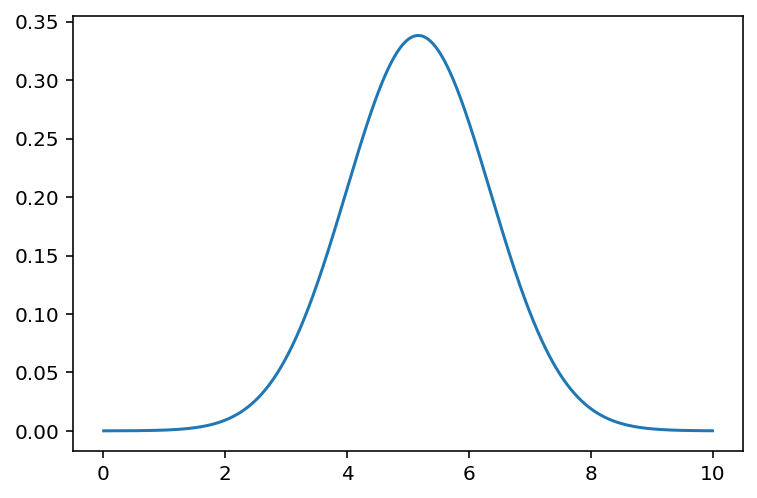

In [17]:
range_r = np.arange(0.01,10,0.01)
next_I, curr_I , N, sigma = 70.0,45.0,7800000.0,1.0/7.5
val_pdf_r = list(map(lambda x:pdf_R_both_D_and_k_normal(x,next_I,curr_I,N,sigma,mean_D,var_D,mean_k,var_k),range_r))
#val_pdf_r = list(map(lambda x:pdf_R_for_single_r(next_I,curr_I,N,x,mean_D,var_D,min_k_value,max_k_value),range_r))
plt.plot(range_r,val_pdf_r)
plt.show()

### calculate AVERAGE $R_t$

In [18]:
def calculate_ave_R_t(next_I,curr_I,N,mean_D,var_D,min_k_value,max_k_value):
    a = curr_I/N
    b = (next_I-curr_I)/curr_I
    #step_sigma = 0.01
    step_k = .01
    #range_sigma = np.arange(mean_sigma-3*np.sqrt(var_sigma),mean_sigma+3*np.sqrt(var_sigma),step_sigma)
    range_k = np.arange(min_k_value,max_k_value,step_k)
    # 
    g1 = list(map(lambda x:(1/(1-x*a)),range_k))
    pdf1 = list(map(lambda x:pdf_k(x,min_k_value,max_k_value),range_k))
    exp1 = sum(np.multiply(g1,pdf1))*step_k
    
    exp2 = 1+ b*mean_D
#     g2 = list(map(lambda x:1+((next_I-curr_I)/(x*curr_I)),range_sigma))
#     pdf2 = list(map(lambda x:pdf_normal(x,mean_sigma,var_sigma),range_sigma))
#     exp2 = sum(np.multiply(g2,pdf2))*step_sigma
    
    print("AVE R",max(exp1*exp2,0))
    return max(exp1*exp2,0)

In [19]:
def mov_ave(row_matrix,window,std_gaussian):
    data_allc = pd.DataFrame(row_matrix.transpose())
    #print(len(data_allc),'\n',data_allc)
    #data_allc=data_allc.rolling(window,win_type='gaussian',min_periods=1,center=True).mean(std=std_gaussian)
    data_allc=data_allc.rolling(window,win_type='parzen', min_periods=1,center=True).mean()
    val_pd = (data_allc.values).transpose()       
    #print(val_pd.shape,'alll \n',val_pd)
    return val_pd

Prediction of R of communites for future

In [20]:
def pred_R(name,matrix_beta, ind_last_day_to_consider_for_reg, num_last_days_used_in_reg,poly_degree):
    num_cities,num_days = matrix_beta.shape[0],matrix_beta.shape[1]
    #x = np.arange(number_last_days_to_use)
    #y_pred = np.zeros((num_day_to_pred,))
    for city in range(num_cities):
        y = matrix_beta[city,ind_last_day_to_consider_for_reg-num_last_days_used_in_reg:ind_last_day_to_consider_for_reg+1]
        x = (1.0)*np.arange(ind_last_day_to_consider_for_reg-num_last_days_used_in_reg,ind_last_day_to_consider_for_reg+1)
        print(x)
        print(y)
        #coeff = np.polynomial.polynomial.polyfit(x, y, poly_degree)
        coeff = np.polyfit(x, y,1)#, 1, w = np.arange(x))
        model = np.poly1d(coeff)
        #for ind_future in range(num_day_to_pred):
        #    pred_y[ind_future] = model(number_last_days_to_use+ind_future)
        #plt.plot(np.arange(num_days),matrix_beta[city,:],'o-r')
        x_future = np.arange(ind_last_day_to_consider_for_reg+1,ind_last_day_to_consider_for_reg+2)
    print(x_future,model(x_future))
    return model(x_future)
#         plt.plot(x_future,model(x_future),'o--')
#         plt.xlabel('Number of days since March 16,2020')
#         #plt.ylabel('Risk Score')
#         plt.ylabel('R')
#         plt.title(name)
#         plt.legend(["Estimation", "Prediction(based on last 14 days)"])
#     plt.show()

Prediction of R of the entire LA county

In [21]:
def pred_R_LA(name,matrix_beta, ind_last_day_to_consider_for_reg, num_last_days_used_in_reg,poly_degree):
    num_cities,num_days = matrix_beta.shape[0],matrix_beta.shape[1]
    #x = np.arange(number_last_days_to_use)
    #y_pred = np.zeros((num_day_to_pred,))
    #for city in range(num_cities):
    y = matrix_beta[0,0,ind_last_day_to_consider_for_reg-num_last_days_used_in_reg:ind_last_day_to_consider_for_reg+1]
    x = (1.0)*np.arange(ind_last_day_to_consider_for_reg-num_last_days_used_in_reg,ind_last_day_to_consider_for_reg+1)
    print("shape beta",matrix_beta.shape, ind_last_day_to_consider_for_reg-num_last_days_used_in_reg,ind_last_day_to_consider_for_reg+1)
    print("len(x)",len(x))
    print("matrix_beta.shape[1]",matrix_beta.shape[1],'\n',len(y))
    #coeff = np.polynomial.polynomial.polyfit(x, y, poly_degree)
    coeff = np.polyfit(x, y,1)#, 1, w = np.arange(x))
    model = np.poly1d(coeff)
    #for ind_future in range(num_day_to_pred):
    #    pred_y[ind_future] = model(number_last_days_to_use+ind_future)
    #plt.plot(np.arange(num_days),matrix_beta[city,:],'o-r')
    x_future = np.arange(ind_last_day_to_consider_for_reg+1,ind_last_day_to_consider_for_reg+2)
    print(x_future,model(x_future))
    return model(x_future)

### Main Func


In [28]:
def main(show_Risk,moving_average_days, Whole_LAcounty,top_i_comm, type_plot,Today_date,future_day_to_be_predicted,til_date,criteria, sigma,gamma,time_to_show):
	dict_county = {} # dictionary of all community objects
	list_communities = [] # list of all community objects
	list_pair = []			
	with open('lacounty_covid.json') as json_file:
		data = json.load(json_file)
		# record all data by creating community classes and fill out their variables 
		for day in sorted([int(k) for k in data.keys()]):
			if day < Today_date :
				#print(day, Today_date )
				for i in range(len(data[str(day)])):
					actual_name_of_community = 	data[str(day)][i][0].strip()
					name_of_community = data[str(day)][i][0].strip().lower().replace(' ','')
					# cleaning city names, removing following prefixes
					prefixex = ['cityof','losangeles-','unincorporated-']
					for word in prefixex:
						name_of_community = name_of_community.replace(word,'') 
					# cleaning confirmed number, e.g. <1 will be 1
					confirmed_cases   = data[str(day)][i][0].strip().lower(),re.sub("[^0-9]", "", data[str(day)][i][1].strip())
					if name_of_community not in dict_county.keys():
						dict_county[name_of_community] = community(name_of_community,actual_name_of_community,Today_date)
						list_communities.append(dict_county[name_of_community ])  
						dict_county[name_of_community].addnumber(day,int(confirmed_cases[1]))
					else:
						dict_county[name_of_community].addnumber(day,int(confirmed_cases[1]))

		# get daily cases of all communities because the cumulative is already obtained
		for communiuty_obj in list_communities:
			for index in range(len(communiuty_obj.confirmed)):
				if index == 0:
					communiuty_obj.confirmed_daily[index] = communiuty_obj.confirmed[index]
				else:
					communiuty_obj.confirmed_daily[index] = communiuty_obj.confirmed[index] - communiuty_obj.confirmed[index-1]	

        
        
# active for community-wise 
		if Whole_LAcounty == False:
			list_selected_communities=[]
			for comm in list_communities:
				for word in ['westhollywood','eastlosangeles','sanpedro','castaic']:
					if comm.name== word:
						list_selected_communities.append(comm)
			#print(len(list_selected_communities))
			#for comm in list_selected_communities:
			#	print(comm.actual_name)
			#return

# active for LA county-wise
#####==============================================================        
		# find communiuty with highest 
		if Whole_LAcounty == True:     
			list_selected_communities = []
			days = list(range(1,Today_date-16+1))
			newlist = sorted(list_communities,key=lambda x: x.confirmed[-1], reverse=True)
			for en,communiuty_obj in enumerate(newlist):
				if communiuty_obj.name != '-investigatedcases' and communiuty_obj.name !='-underinvestigation' and top_i_comm > 0:
					# append this city to the list
					if check_if_community_is_in_dic_pop(communiuty_obj.actual_name):
						list_selected_communities.append(communiuty_obj)
						#plt.plot(days, communiuty_obj.plot_info(type_plot),'o-',label = communiuty_obj.actual_name)
						top_i_comm -= 1
		
#####==============================================================
		#create_csv_file(list_selected_communities)
		# create matrix of I for top communities (highest number of confirmed cases)
		# matrix_I is matrix I for top communities until "til_date" (for training)
		# matrix_I = create_matrix(list_selected_communities, type_plot,til_date)
		# ref_matrix_I is matrix I for top communities for all days 				
		ref_matrix_I = create_matrix(list_selected_communities, 'daily',Today_date-16)

        
		############################################################
		######################## Smoothing #########################
		#n=7 
		#ref_matrix_I = moving_ave_on_matrix(ref_matrix_I,moving_average_days)
		ref_matrix_I = mov_ave(ref_matrix_I,moving_average_days,10)
		#padded_I = np.zeros((len(list_selected_communities),Today_date-16 + n-1 ))

# 		padded_I[:,(n-1)//2:-(n-1)//2]=ref_matrix_I
# 		for city in range(ref_matrix_I.shape[0]):
# 			ref_matrix_I[city,:] = movingaverage(padded_I[city,:],n) 
            
		#############################################################            
		# making ref_matrix_I non decreasing
		# ref_matrix_I = fix_matrix_I(ref_matrix_I)


		if Whole_LAcounty == True:        
#################################################################
#             For WHOLE LA county 
#################################################################
			type_plot ='daily'


			all_communities_available_in_pop_list = []        
			for en,communiuty_obj in enumerate(newlist):
				if communiuty_obj.name != '-investigatedcases' and communiuty_obj.name !='-underinvestigation':
					if check_if_community_is_in_dic_pop(communiuty_obj.actual_name):
						all_communities_available_in_pop_list.append(communiuty_obj)
                    
			vec_pop_all_communities_available = get_population_vec(all_communities_available_in_pop_list) 
			sum_population_all_communities = np.zeros(1)
			sum_population_all_communities[0] = np.sum(vec_pop_all_communities_available)        
			all_communities_matrix_I = create_matrix(all_communities_available_in_pop_list, type_plot,Today_date-16)
			all_communities_matrix_I = fix_matrix_I(all_communities_matrix_I)
			#all_communities_matrix_I = moving_ave_on_matrix(all_communities_matrix_I,moving_average_days)


			print("s",all_communities_matrix_I.shape)
			summed_over_all_comm_matrix_I = np.reshape(all_communities_matrix_I.sum(axis=0),(1,all_communities_matrix_I.shape[1]))
			print("sum",summed_over_all_comm_matrix_I.shape)

			         

			summed_over_all_comm_matrix_I = mov_ave(summed_over_all_comm_matrix_I,moving_average_days,1000)
			#summed_over_all_comm_matrix_I = moving_ave_on_matrix(summed_over_all_comm_matrix_I,moving_average_days)
			beta_lacounty = calculating_beta(summed_over_all_comm_matrix_I,sum_population_all_communities,sigma,Today_date, all_communities_available_in_pop_list)

            
			####################################################### 
			if show_Risk == True:
				risk_lacounty = (10000)*np.multiply(beta_lacounty/sigma,summed_over_all_comm_matrix_I[:,:-1])/(1.0*sum_population_all_communities)
				#print("alo\n",risk_lacounty.shape)
				#return 0           
# 				pred_R('LA couonty',risk_lacounty , 75,14,5,2)
				output_pred =[]
				past_num_days_to_pred = 30
				num_days_for_considering_reg_in = Today_date-16-1 # or fix 83
				for day_to_pred in range(past_num_days_to_pred):
					output_pred.append(max(0,pred_R_LA('Whole LA County',risk_lacounty[np.newaxis,:] ,num_days_for_considering_reg_in-past_num_days_to_pred+day_to_pred,7,1)))
					#print(output_pred)
					#return 0
				clear_output(wait=True)
				plt.figure()
				plt.plot(np.arange(risk_lacounty.shape[1]),risk_lacounty[0,:],'o-r')
				#plt.plot(np.arange(risk_lacounty.shape[1]-past_num_days_to_pred,risk_lacounty.shape[1]),output_pred,'o--')
				plt.ylabel('Risk Score')
				plt.xlabel('Number of Days Since March 16, 2020')
				plt.title('Whole LA County')
				#plt.legend(["Estimation", "Prediction(based on last 7 days)"])
				plt.legend(["Estimation"])
				#plt.legend(["Estimation"])
				return 0


# 				return 0           
				R = beta_lacounty/sigma
				#R = mov_ave(R,7,1.5)
				pred_R('LA couonty',R , 75,7,5,2)
				return 0
			###################################################
			#print("beta_lacounty",beta_lacounty.shape)    
        
			#D_lacounty,U_lacounty=beta_lacounty,beta_lacounty    
        
			margin=np.zeros((2,beta_lacounty.shape[1]))
			#print("marg",summed_over_all_comm_matrix_I)
			for ind_cont_rate in range(beta_lacounty.shape[1]):
				cont_rate = beta_lacounty[0,ind_cont_rate]
				print(ind_cont_rate,summed_over_all_comm_matrix_I[0,ind_cont_rate+1])
				next_I,curr_I, N = summed_over_all_comm_matrix_I[0,ind_cont_rate+1],summed_over_all_comm_matrix_I[0,ind_cont_rate],sum_population_all_communities[0]
				print("population",N,next_I,curr_I)
				#out_CI=calculate_CI_delta(next_I,curr_I,sigma,N,cont_rate/sigma,0.95)

				#print("summ",sum(list(map(lambda x:pdf_R_for_single_r(next_I,curr_I,N,x),np.arange(0.01,200,.05)))))
				ave_r = calculate_ave_R_t(next_I,curr_I,N,mean_D,var_D,min_k_value,max_k_value)
				#out_CI= cal_delta(next_I,curr_I,N,ave_r,.95,mean_D,var_D,min_k_value,max_k_value)
				out_CI= cal_delta_closed_form_pdf_R(next_I,curr_I,N,ave_r,.95,mean_D,var_D,mean_k,var_k)                
				print("Current index out of",ind_cont_rate,beta_lacounty.shape[1])
				margin[0,ind_cont_rate]=out_CI[0]
				margin[1,ind_cont_rate]=out_CI[1]
			print("hhhh",margin.shape)
			#return 0
			D_lacounty,U_lacounty=np.zeros((1,beta_lacounty.shape[1])),np.zeros((1,beta_lacounty.shape[1]))            
			D_lacounty =  margin[0,:]
			U_lacounty =  margin[1,:]
			D_lacounty =  D_lacounty[np.newaxis,:]
			U_lacounty =  U_lacounty[np.newaxis,:]
			##############################
			#D_lacounty,U_lacounty = calculating_R_marigins(summed_over_all_comm_matrix_I,sum_population_all_communities,sigma,Today_date, all_communities_available_in_pop_list)
			print("shape",D_lacounty.shape)
			clear_output(wait=True)
			fig, ax = plt.subplots(figsize=(600/72,400/72))
			state_name = "Daily $R_0$ for LA county"
			result = create_dataframe_for_R(0,beta_lacounty,sigma,U_lacounty,D_lacounty)
			plot_rt(result, ax, state_name)
			#print("val")
			#print(result)
			ax.set_title(f'{state_name}')
			ax.set_ylim(0.1,7.0)
			ax.xaxis.set_major_locator(mdates.WeekdayLocator())
			ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))

        
		else:     
# 			list_selected_communities=[]
# 			for comm in list_communities:
# 				if comm.name in ['glendale','eastlosangeles','sanpedro','caistic']:
# 					list_selected_communities.append(comm)
                

			print([obj.actual_name for obj in list_selected_communities])
			vec_population = get_population_vec(list_selected_communities)
			name_top_selected_communities = [obj.actual_name for obj in list_selected_communities]
			#name_top_selected_communities =['Carson', 'South Gate', 'Burbank', 'East Los Angeles', 'Hollywood', 'Downey']
			matrix_beta = calculating_beta(ref_matrix_I,vec_population,sigma,Today_date, name_top_selected_communities)
			#matrix_beta = np.zeros_like(ref_matrix_I)
        
			vec_population = get_population_vec(list_selected_communities)
			# find intial I for each city because the derivation equations are sensirtive to INTIAL values
			# initial_infection_for_SIR = find_intial_non_zero_val_Infection(ref_matrix_I)
			# plot_SIR(matrix_beta,sigma,vec_population, initial_infection_for_SIR, time_to_show,name_top_selected_communities)

			##=========================================
			if show_Risk == True:
				for ind in range(matrix_beta.shape[0]):
					risk_comm = (10000)*np.multiply(matrix_beta[ind,:]/sigma,ref_matrix_I[ind,:-1])/(1.0*vec_population[ind])
					print("city\n",ind)
                
                
					output_pred =[]
					past_num_days_to_pred = 30
					num_days_for_considering_reg_in = Today_date-16-1 # or fix 83
					for day_to_pred in range(past_num_days_to_pred):
						output_pred.append(max(0,pred_R(list_selected_communities[ind].actual_name,risk_comm[np.newaxis,:] ,num_days_for_considering_reg_in-past_num_days_to_pred+day_to_pred,7,1)))
					#print(output_pred)
					#return 0
					clear_output(wait=True)
					plt.figure()
					plt.plot(np.arange(len(risk_comm)),risk_comm,'o-r')
					plt.plot(np.arange(len(risk_comm)-past_num_days_to_pred,len(risk_comm)),output_pred,'o--')
					plt.ylabel('Risk Score')
					plt.xlabel('Number of Days Since March 16, 2020')
					plt.title(list_selected_communities[ind].actual_name)
					plt.legend(["Estimation", "Prediction(based on last 7 days)"])
					#plt.legend(["Estimation"])                    
					#pred_R(list_selected_communities[ind].actual_name,risk_comm[np.newaxis,:] , 75,14,1)    

					#R = matrix_beta[ind,:]/sigma
					#R = mov_ave(R,7,1.5)
					#pred_R(list_selected_communities[ind].actual_name,R[np.newaxis,:] , 75,2,5,2)
				return 0    
			##=========================================            
			######D,U = calculating_R_marigins(ref_matrix_I,vec_population,sigma,Today_date, name_top_selected_communities)
			#D,U = matrix_beta,matrix_beta
			D,U=np.zeros((matrix_beta.shape[0],matrix_beta.shape[1])),np.zeros((matrix_beta.shape[0],matrix_beta.shape[1]))  
			for ind_city in range(ref_matrix_I.shape[0]):
				print("City",ind_city)              
				margin=np.zeros((2,matrix_beta.shape[1]))
				for ind_cont_rate in range(matrix_beta.shape[1]):
					next_I, curr_I = ref_matrix_I[ind_city,ind_cont_rate+1],ref_matrix_I[ind_city,ind_cont_rate]
					N = vec_population[ind_city]
					ave_r = calculate_ave_R_t(next_I,curr_I,N,mean_D,var_D,min_k_value,max_k_value)
					#out_CI= cal_delta(next_I,curr_I,N,ave_r,.95,mean_D,var_D,min_k_value,max_k_value)
					out_CI=cal_delta_closed_form_pdf_R(next_I,curr_I,N,ave_r,.95,mean_D,var_D,mean_k,var_k)
					#print("Current index out of",ind_city, ind_cont_rate)
					margin[0,ind_cont_rate]=out_CI[0]
					margin[1,ind_cont_rate]=out_CI[1] 
				D_lacounty =  margin[0,:]
				U_lacounty =  margin[1,:]
				D[ind_city,:] =  D_lacounty[np.newaxis,:]
				U[ind_city,:] =  U_lacounty[np.newaxis,:]                    
##================== Plotting =====================
			ncols = 2
			nrows = int(np.ceil(len(name_top_selected_communities) / ncols))
			clear_output(wait=True)
			# fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15, nrows*3))
			fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15, nrows*4))
			for i, ax in enumerate(axes.flatten()):
				state_name = name_top_selected_communities[i]
				#result = create_dataframe_for_R(i,matrix_beta,sigma,U,D)
				result = create_dataframe_for_R(i,matrix_beta,sigma,U,D)
				plot_rt(result, axes.flat[i], state_name)
			#import pdb;pdb.set_trace()        
			fig.tight_layout()
			fig.set_facecolor('w')

        
# if __name__ == "__main__":
# 	show_Risk = True   
# 	Whole_LAcounty = True
# 	top_k_community_with_highest_confirmed = 3
# 	moving_average_days = 7
# 	# Display mode: daily or cumulative
# 	display_mode = 'cumulative'
# 	number_of_days_passed_from_16th = 103 - 16 + 1	
# 	number_of_days_passed_from_16th_used_for_prediction =39
# 	future_day_to_be_predicted = 1
# 	criteria = 'train'
# 	# SIR model general settings
# 	sigma = 1.0/7.5 # 5.2
# 	gamma = 1.0/(2.3)
# 	time_to_show = 300 
# 	main(show_Risk,moving_average_days,Whole_LAcounty,top_k_community_with_highest_confirmed,display_mode, 16 + number_of_days_passed_from_16th,future_day_to_be_predicted,number_of_days_passed_from_16th_used_for_prediction,criteria,sigma,gamma,time_to_show)
        

### Parameter Setting for plotting R and Risk scores

In [29]:
moving_average_days = 14
number_of_days_passed_from_16th = 103 - 16 + 1
sigma = 1.0/7.5 # 5.2
gamma = 1.0/(2.3)

### Plotting the risk of the entire LA county along 30 days of predcition using linear regression on the risk score of the last 7 days

0

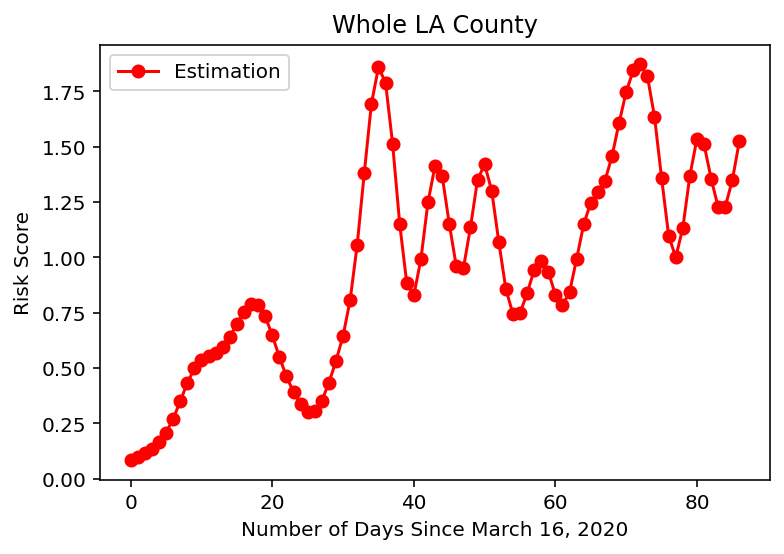

In [30]:
show_Risk = True   # True: showing risk score , False: showing Rt and its confidence interval
Whole_LAcounty = True   # True: plot for entire LA county , False: plot for the 4 communities
top_k_community_with_highest_confirmed = 3
#moving_average_days = 7
# Display mode: daily or cumulative
display_mode = 'cumulative'
#number_of_days_passed_from_16th = 99 - 16 + 1	
number_of_days_passed_from_16th_used_for_prediction =39
future_day_to_be_predicted = 1
criteria = 'train'
# SIR model general settings
# sigma = 1.0/7.5 # 5.2
# gamma = 1.0/(2.3)
time_to_show = 300 
main(show_Risk,moving_average_days,Whole_LAcounty,top_k_community_with_highest_confirmed,display_mode, 16 + number_of_days_passed_from_16th,future_day_to_be_predicted,number_of_days_passed_from_16th_used_for_prediction,criteria,sigma,gamma,time_to_show)
        

### Plotting the risk of 4 communities, namely 'West Hollywood', 'East Los Angeles', 'Castaic', and 'San Pedro' along 30 days of predcition using linear regression on the risk score of the last 7 days 

0

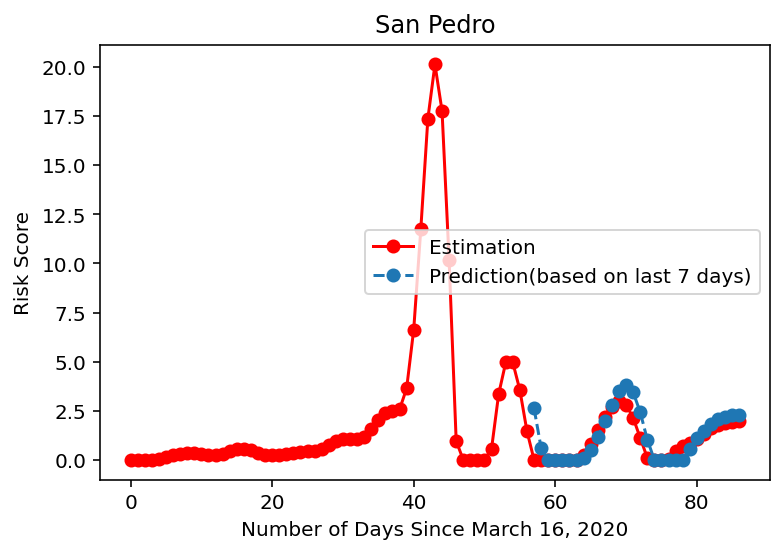

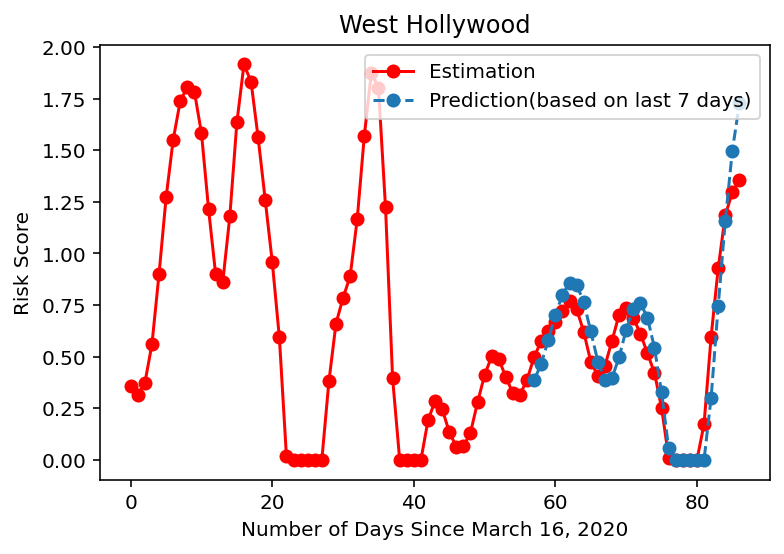

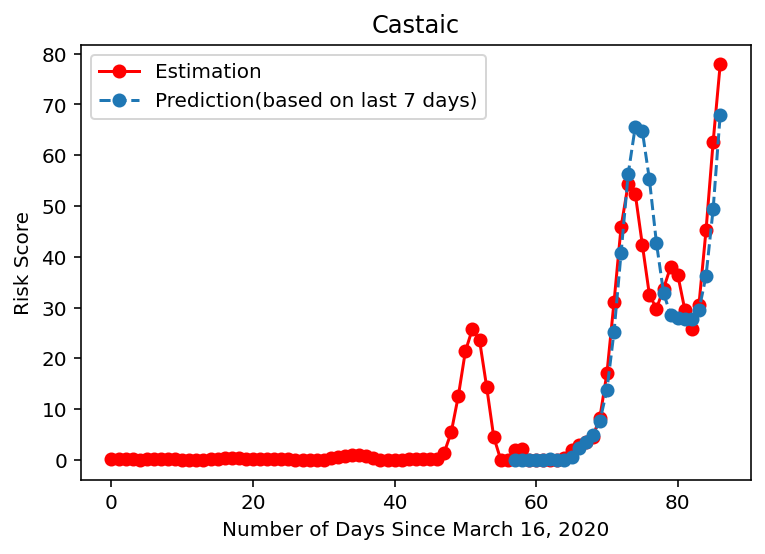

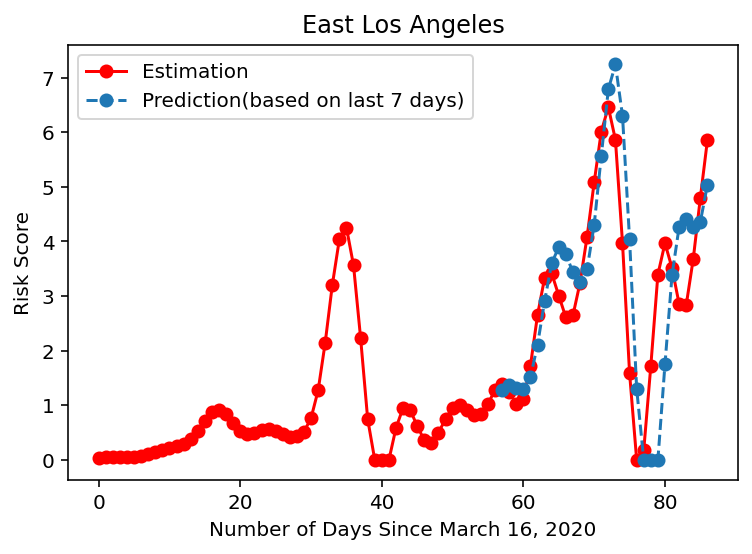

In [25]:
show_Risk = True   # True: showing risk score , False: showing Rt and its confidence interval
Whole_LAcounty = False  # True: plot for entire LA county , False: plot for the 4 communities
top_k_community_with_highest_confirmed = 3
#moving_average_days = 7
# Display mode: daily or cumulative
display_mode = 'cumulative'
#number_of_days_passed_from_16th = 99 - 16 + 1	
number_of_days_passed_from_16th_used_for_prediction =39
future_day_to_be_predicted = 1
criteria = 'train'
# SIR model general settings
#sigma = 1.0/7.5 # 5.2
#gamma = 1.0/(2.3)
time_to_show = 300 
main(show_Risk,moving_average_days,Whole_LAcounty,top_k_community_with_highest_confirmed,display_mode, 16 + number_of_days_passed_from_16th,future_day_to_be_predicted,number_of_days_passed_from_16th_used_for_prediction,criteria,sigma,gamma,time_to_show)
        

### Plotting the Infection Rate $R_t$ and its confidence interval for the entire LA county

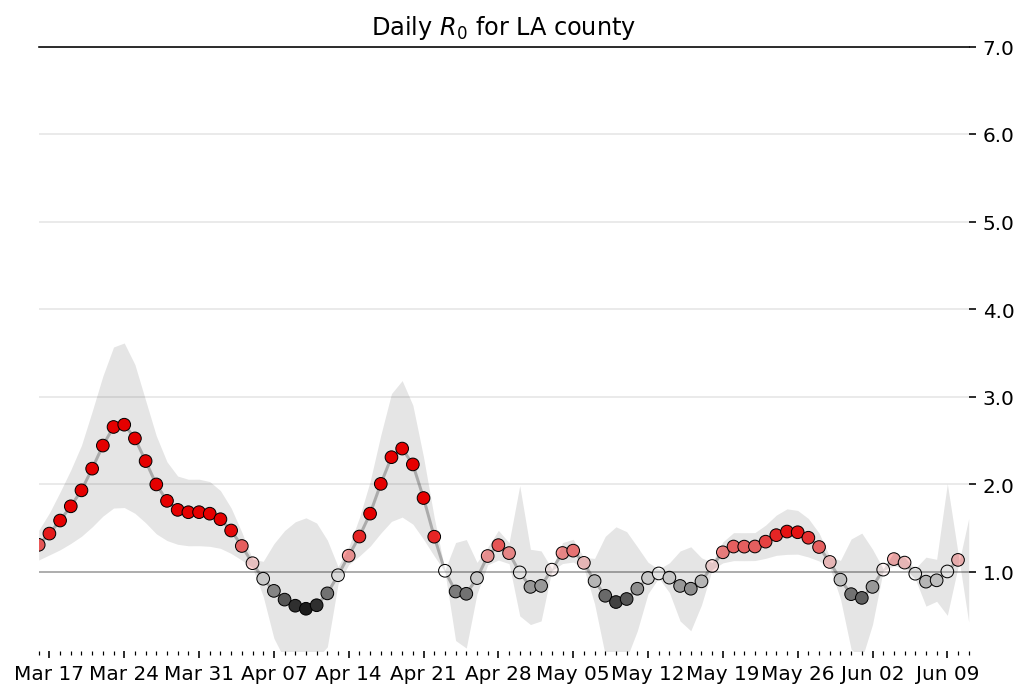

In [26]:
show_Risk = False # True: showing risk score , False: showing Rt and its confidence interval  
Whole_LAcounty = True  # True: plot for entire LA county , False: plot for the 4 communities
top_k_community_with_highest_confirmed = 3
#moving_average_days = 7
# Display mode: daily or cumulative
display_mode = 'cumulative'
#number_of_days_passed_from_16th = 99 - 16 + 1	
number_of_days_passed_from_16th_used_for_prediction =39
future_day_to_be_predicted = 1
criteria = 'train'
# SIR model general settings
#sigma = 1.0/7.5 # 5.2
#gamma = 1.0/(2.3)
time_to_show = 300 
main(show_Risk,moving_average_days,Whole_LAcounty,top_k_community_with_highest_confirmed,display_mode, 16 + number_of_days_passed_from_16th,future_day_to_be_predicted,number_of_days_passed_from_16th_used_for_prediction,criteria,sigma,gamma,time_to_show)
        

### Plotting the Infection Rate $R_t$ and its confidence interval for 4 communites, namely 'West Hollywood', 'East Los Angeles', 'Castaic', and 'San Pedro'

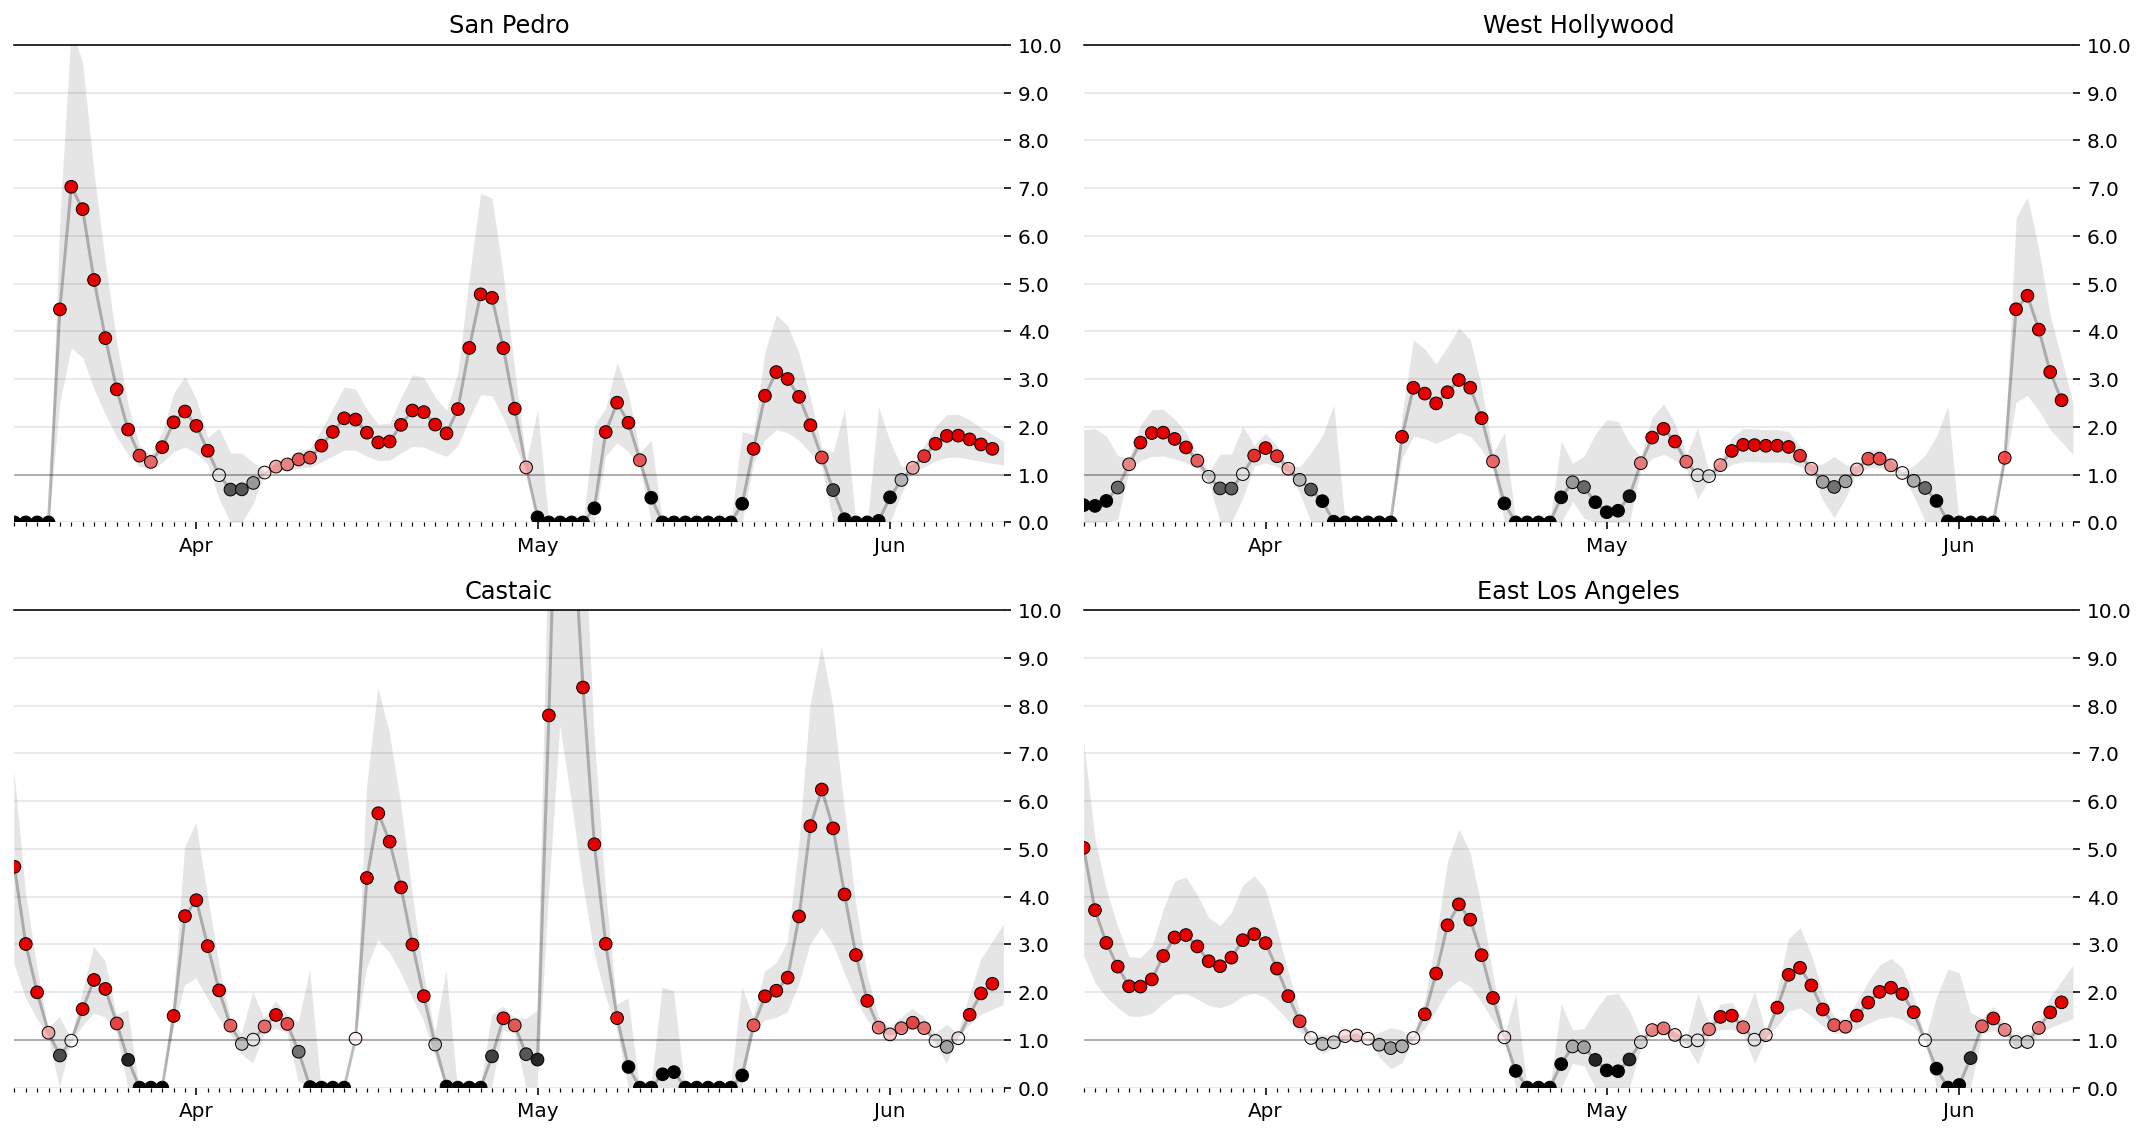

In [27]:
show_Risk = False # True: showing risk score , False: showing Rt and its confidence interval   
Whole_LAcounty = False  # True: plot for entire LA county , False: plot for the 4 communities
top_k_community_with_highest_confirmed = 3
#moving_average_days = 7
# Display mode: daily or cumulative
display_mode = 'cumulative'
#number_of_days_passed_from_16th = 99 - 16 + 1	
number_of_days_passed_from_16th_used_for_prediction =39
future_day_to_be_predicted = 1
criteria = 'train'
# SIR model general settings
#sigma = 1.0/7.5 # 5.2
#gamma = 1.0/(2.3)
time_to_show = 300 
main(show_Risk,moving_average_days,Whole_LAcounty,top_k_community_with_highest_confirmed,display_mode, 16 + number_of_days_passed_from_16th,future_day_to_be_predicted,number_of_days_passed_from_16th_used_for_prediction,criteria,sigma,gamma,time_to_show)
        